In [50]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt

import sklearn.metrics as metrics

import pickle

from google.colab import files

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder

from sklearn import tree

### Load dataset and preprocess

In [2]:
# from google.colab import files
uploaded = files.upload()

Saving data_all_raw.csv to data_all_raw.csv


In [74]:
### Single family homes in SF Bay Area from June 2019, more details in:
### https://towardsdatascience.com/house-hunting-in-the-san-francisco-bay-area-deal-hunting-using-machine-learning-3ed6fc8e8991
data_all_raw = pd.read_csv('data_all_raw.csv')

In [75]:
# format/clean -- select columns of interest, drop rows with zeros, NaNs
data_all_temp2 = data_all_raw.dropna()
data_all_temp3 = data_all_temp2[(data_all_temp2 != 0).all(1)]

# get rid of some outliers
### Remove all houses with home size > 5000 sq ft, or lot size > 20,000 sq ft, or price > $5 million, etc.
data_all_temp4 = data_all_temp3[data_all_temp3['Home size'] < 5000]
data_all_temp5 = data_all_temp4[data_all_temp4['Lot size'] < 20000]
data_all_temp6 = data_all_temp5[data_all_temp5['Price'] < 5000000]
data_all_temp7 = data_all_temp6[data_all_temp6['Beds'] < 6]
data_all_temp8 = data_all_temp7[data_all_temp7['Baths'] < 6]

# remove spaces in column names - necessary for OLS?
data_all_temp8.columns = data_all_temp8.columns.str.replace(' ', '_')
data_all = data_all_temp8

# check for multicollinearity
correlations = data_all.corr()

# query count, mean, stdev etc. of selected data
data_all.describe()

## option to select one zipcode
#zipcode = 94401
#data_subset = data_all[data_all['Zip'] == zipcode]

,Unnamed:_0,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
count,5758.000000,5758.000000,5.758000e+03,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000
mean,3641.553838,94619.864536,1.194509e+06,3.426016,2.318861,1906.304967,6704.043175,37.698938,-122.115052,84.225947,84.442862,50.217367,68.383814
std,2020.278018,331.993813,7.394026e+05,0.851077,0.842316,773.425567,3411.103629,0.260709,0.231021,26.950540,33.735555,19.453980,28.831007
min,1.000000,94002.000000,1.290000e+05,1.000000,1.000000,107.000000,436.000000,37.150065,-122.687775,8.000000,5.000000,17.100000,5.000000
25%,1939.250000,94517.000000,6.790000e+05,3.000000,2.000000,1329.000000,4500.000000,37.465193,-122.274202,65.000000,60.000000,33.100000,47.000000
50%,3658.500000,94579.000000,9.959750e+05,3.000000,2.000000,1750.000000,6064.000000,37.739942,-122.102690,90.000000,85.000000,48.800000,65.000000
75%,5283.750000,94903.000000,1.469722e+06,4.000000,3.000000,2330.000000,8102.000000,37.926986,-121.943836,100.000000,115.000000,65.300000,90.000000
max,7145.000000,95391.000000,4.999888e+06,5.000000,5.500000,4955.000000,19602.000000,38.149218,-121.532356,170.000000,150.000000,89.800000,130.000000


In [76]:
print('num rows: ', len(data_all))

num rows:  5758


In [77]:
data_all.head()

,Unnamed:_0,Address,City,State,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
1,1,1909 Hillman Ave,Belmont,CA,94002,1595000,4,2.0,2220.0,3999.0,37.521972,-122.294079,63,33,77.9,33
2,2,641 Waltermire St,Belmont,CA,94002,899999,2,1.0,840.0,4234.0,37.520233,-122.273144,63,33,77.9,33
3,3,2706 Sequoia Way,Belmont,CA,94002,1588000,3,2.0,1860.0,5210.0,37.520192,-122.309437,63,33,77.9,33
4,4,1568 Winding Way,Belmont,CA,94002,1999000,4,3.5,2900.0,16117.2,37.524280,-122.291241,63,33,77.9,33
5,5,1440 5th Ave,Belmont,CA,94002,1249950,2,1.0,1170.0,5001.0,37.516227,-122.272763,63,33,77.9,33


In [78]:
# Regression metrics

# https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does
# https://machinelearningmastery.com/regression-metrics-for-machine-learning/

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
# R^2 (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a
# score of 0.0.

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
# MSE is Mean squared error regression loss.

# The MSE is calculated as the mean or average of the squared differences between predicted and expected target values in a dataset.
# The units of the MSE are squared units.
# For example, if the value represents “dollars,” then the MSE will be “squared dollars.” 
# This can be confusing for stakeholders; therefore, when reporting results, often the root mean squared error (RMSE) is used instead
def regression_results(y_true, y_pred):
    # explained_variance=metrics.explained_variance_score(y_true, y_pred)
    # mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    # median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    # r2 = metrics.r2_score(y_true, y_pred)

    # print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    # print('R_squared: ', round(r2,4))
    # print('MAE: ', round(mean_absolute_error,4))
    # print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [79]:
def display_scores (scores):
    print("Scores:", scores)
    print("\n Mean:", scores.mean())
    print("\n Standard deviation:", scores.std(),"\n")

In [80]:
# # Uncomment to check what city names are available from dataset as inputs
# encoder = OrdinalEncoder()
# city_cat =  data_all[["City"]]
# city_cat_encoded = encoder.fit_transform(city_cat)
# encoder.categories_

In [81]:
# Build pipeline to do any preprocessing on the raw input dataset, 
# like 1-hot encode city names
# return: Pipeline object to run fit_transform on training data, and
# transform on test data
def build_pipeline():
    # Setting remainder='passthrough' will mean that all columns not specified in 
    # the list of "transformers" will be passed through without transformation, 
    # instead of being dropped.
    cat_attribs = ["City"]
    full_pipeline = ColumnTransformer([
     ("cat", OneHotEncoder(), cat_attribs),
     ], remainder='passthrough')
    return full_pipeline

In [82]:
# check what is Spbl
# probably web scraping partially failed on a San Pablo house, got this city name instead
data_all[data_all["City"] == "Spbl"].head()

,Unnamed:_0,Address,City,State,Zip,Price,Beds,Baths,Home_size,Lot_size,Latitude,Longitude,SF_time,PA_time,School_score,Commute_time
5140,5147,1947 20th St,Spbl,CA,94806,370000,3,1.0,720.0,3049.0,37.959853,-122.349674,90,120,30.0,90
5160,5167,1947 20th St,Spbl,CA,94806,370000,3,1.0,720.0,3049.0,37.959853,-122.349674,90,120,30.0,90


## Train and Test Model

If model has no cross-validation, data is split into train and test.

If model has cross-validation, data is split into train, validation, and test.

Best model so far: **10-fold cross validated Decision Tree** but it overfits


Model results, rounded to 2 decimal places:

<!-- ### Listing data only - home_size, lot_size, beds, baths

**Linear regression**

Test set RMSE:  $605,096.22

**Decision tree**

Test set RMSE:  $19,314.05

**10-fold cross validated decision tree**

Eval set RMSE Mean: $861,902.94

Test set RMSE:  $19,314.05

**10-fold cross validated linear regression**

Eval set RMSE Mean: $615,793.63

Test set RMSE:  $605,096.22

**10-fold cross validated random forest regressor**

Eval set RMSE Mean: $658,179.03

Test set RMSE:  $189,566.31


### With location - home_size, lot_size, beds, baths, latitude, longitude
**10-fold cross validated decision tree**

Eval set RMSE Mean: $497,890.38

Test set RMSE:  $5,719.33 -->


### With location and city name - home_size, lot_size, beds, baths, latitude, longitude, city
**10-fold cross validated linear regression**

Eval set RMSE Mean: $625,182.58

Test set RMSE:  $294,678.75

**10-fold cross validated logistic regression**

Eval set RMSE Mean: $803,707.94

Test set RMSE:  $804,567.22

**10-fold cross validated random forest regressor**

Eval set RMSE Mean: $375,878.46

Test set RMSE:  $82,508.71

**10-fold cross validated MLP regressor (solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)**

Eval set RMSE Mean: $617,178.81

Test set RMSE:  $601,742.74

**10-fold cross validated decision tree**

Eval set RMSE Mean: $475,438.04

Test set RMSE:  $5,719.33

In [83]:
### sklearn ###

# set features (independent) and labels (dependent)
y = data_all['Price']

# before commute, school quality data
# x2 = data_all[['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude']]
x2 = data_all[['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude', 'City']]


pipeline = build_pipeline()
print("built pipeline")
# prepared dataset
x2 = pipeline.fit_transform(x2)
   
# fit data
# regressor = LinearRegression()
regressor = DecisionTreeRegressor()
# regressor = RandomForestRegressor()
# regressor = LogisticRegression()
# regressor = MLPRegressor()
# regressor = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
regressor.fit(x2, y)

# Train a model with 10-fold cross validation.
# Randomly splits the training set into 10 distinct subsets called folds, 
# then it trains and evaluates the Decision Tree model 10 times, 
# picking a different fold for evaluation every time and training on the 
# other 9 folds. The result is an array containing the 10 evaluation scores
# Note: sklearn cross validation expects a utility function, i.e. greater is better,
# rather than cost function like MSE where lower is better.
# That's why -scores is computed to get the RMSE.
scores = cross_val_score(regressor, x2, y, scoring="neg_mean_squared_error", cv = 10)
tree_rmse_scores  = np.sqrt(-scores)
display_scores(tree_rmse_scores)

# predict values based on model
y_pred2 = regressor.predict(x2) # listing data only

# calculate difference between predicted and actual prices
diff = round((y - y_pred2), 6)

# add difference to full data set
data_all['Price_difference'] = diff

built pipeline
Scores: [683975.79514976 868932.3904539  302006.77910145 222451.43983588
 297955.15224339 205650.14597751 389318.62623487 992391.32503624
 417842.58476887 319721.91623547]

 Mean: 470024.615503734

 Standard deviation: 264314.40612304694 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [84]:
# Root Mean Squared Error as the evaluation metric
regression_results(y, y_pred2)

RMSE:  5719.3313


### Save trained model and pipeline

In [85]:
# save the model
file = open("house_price_model.pkl", 'wb')
pickle.dump(regressor, file)
file.close()

In [86]:
# save the pipeline fitted on training dataset
file = open("house_price_pipeline.pkl", 'wb')
pickle.dump(pipeline, file)
file.close()

### View Decision Tree

[Text(0.5, 0.9, 'X[103] <= 2379.0\nsquared_error = 546621212994.639\nsamples = 5758\nvalue = 1194508.889'),
 Text(0.25, 0.7, 'X[107] <= 37.606\nsquared_error = 270680192097.855\nsamples = 4416\nvalue = 1010432.921'),
 Text(0.125, 0.5, 'X[108] <= -121.951\nsquared_error = 284276632810.494\nsamples = 1565\nvalue = 1381822.224'),
 Text(0.0625, 0.3, 'X[103] <= 1644.5\nsquared_error = 335116284965.004\nsamples = 918\nvalue = 1587685.742'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'X[103] <= 1690.0\nsquared_error = 66694645232.769\nsamples = 647\nvalue = 1089731.482'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'X[108] <= -122.401\nsquared_error = 145941070956.261\nsamples = 2851\nvalue = 806566.116'),
 Text(0.3125, 0.3, 'X[103] <= 1944.0\nsquared_error = 226797210829.229\nsamples = 579\nvalue = 1237736.389'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Te

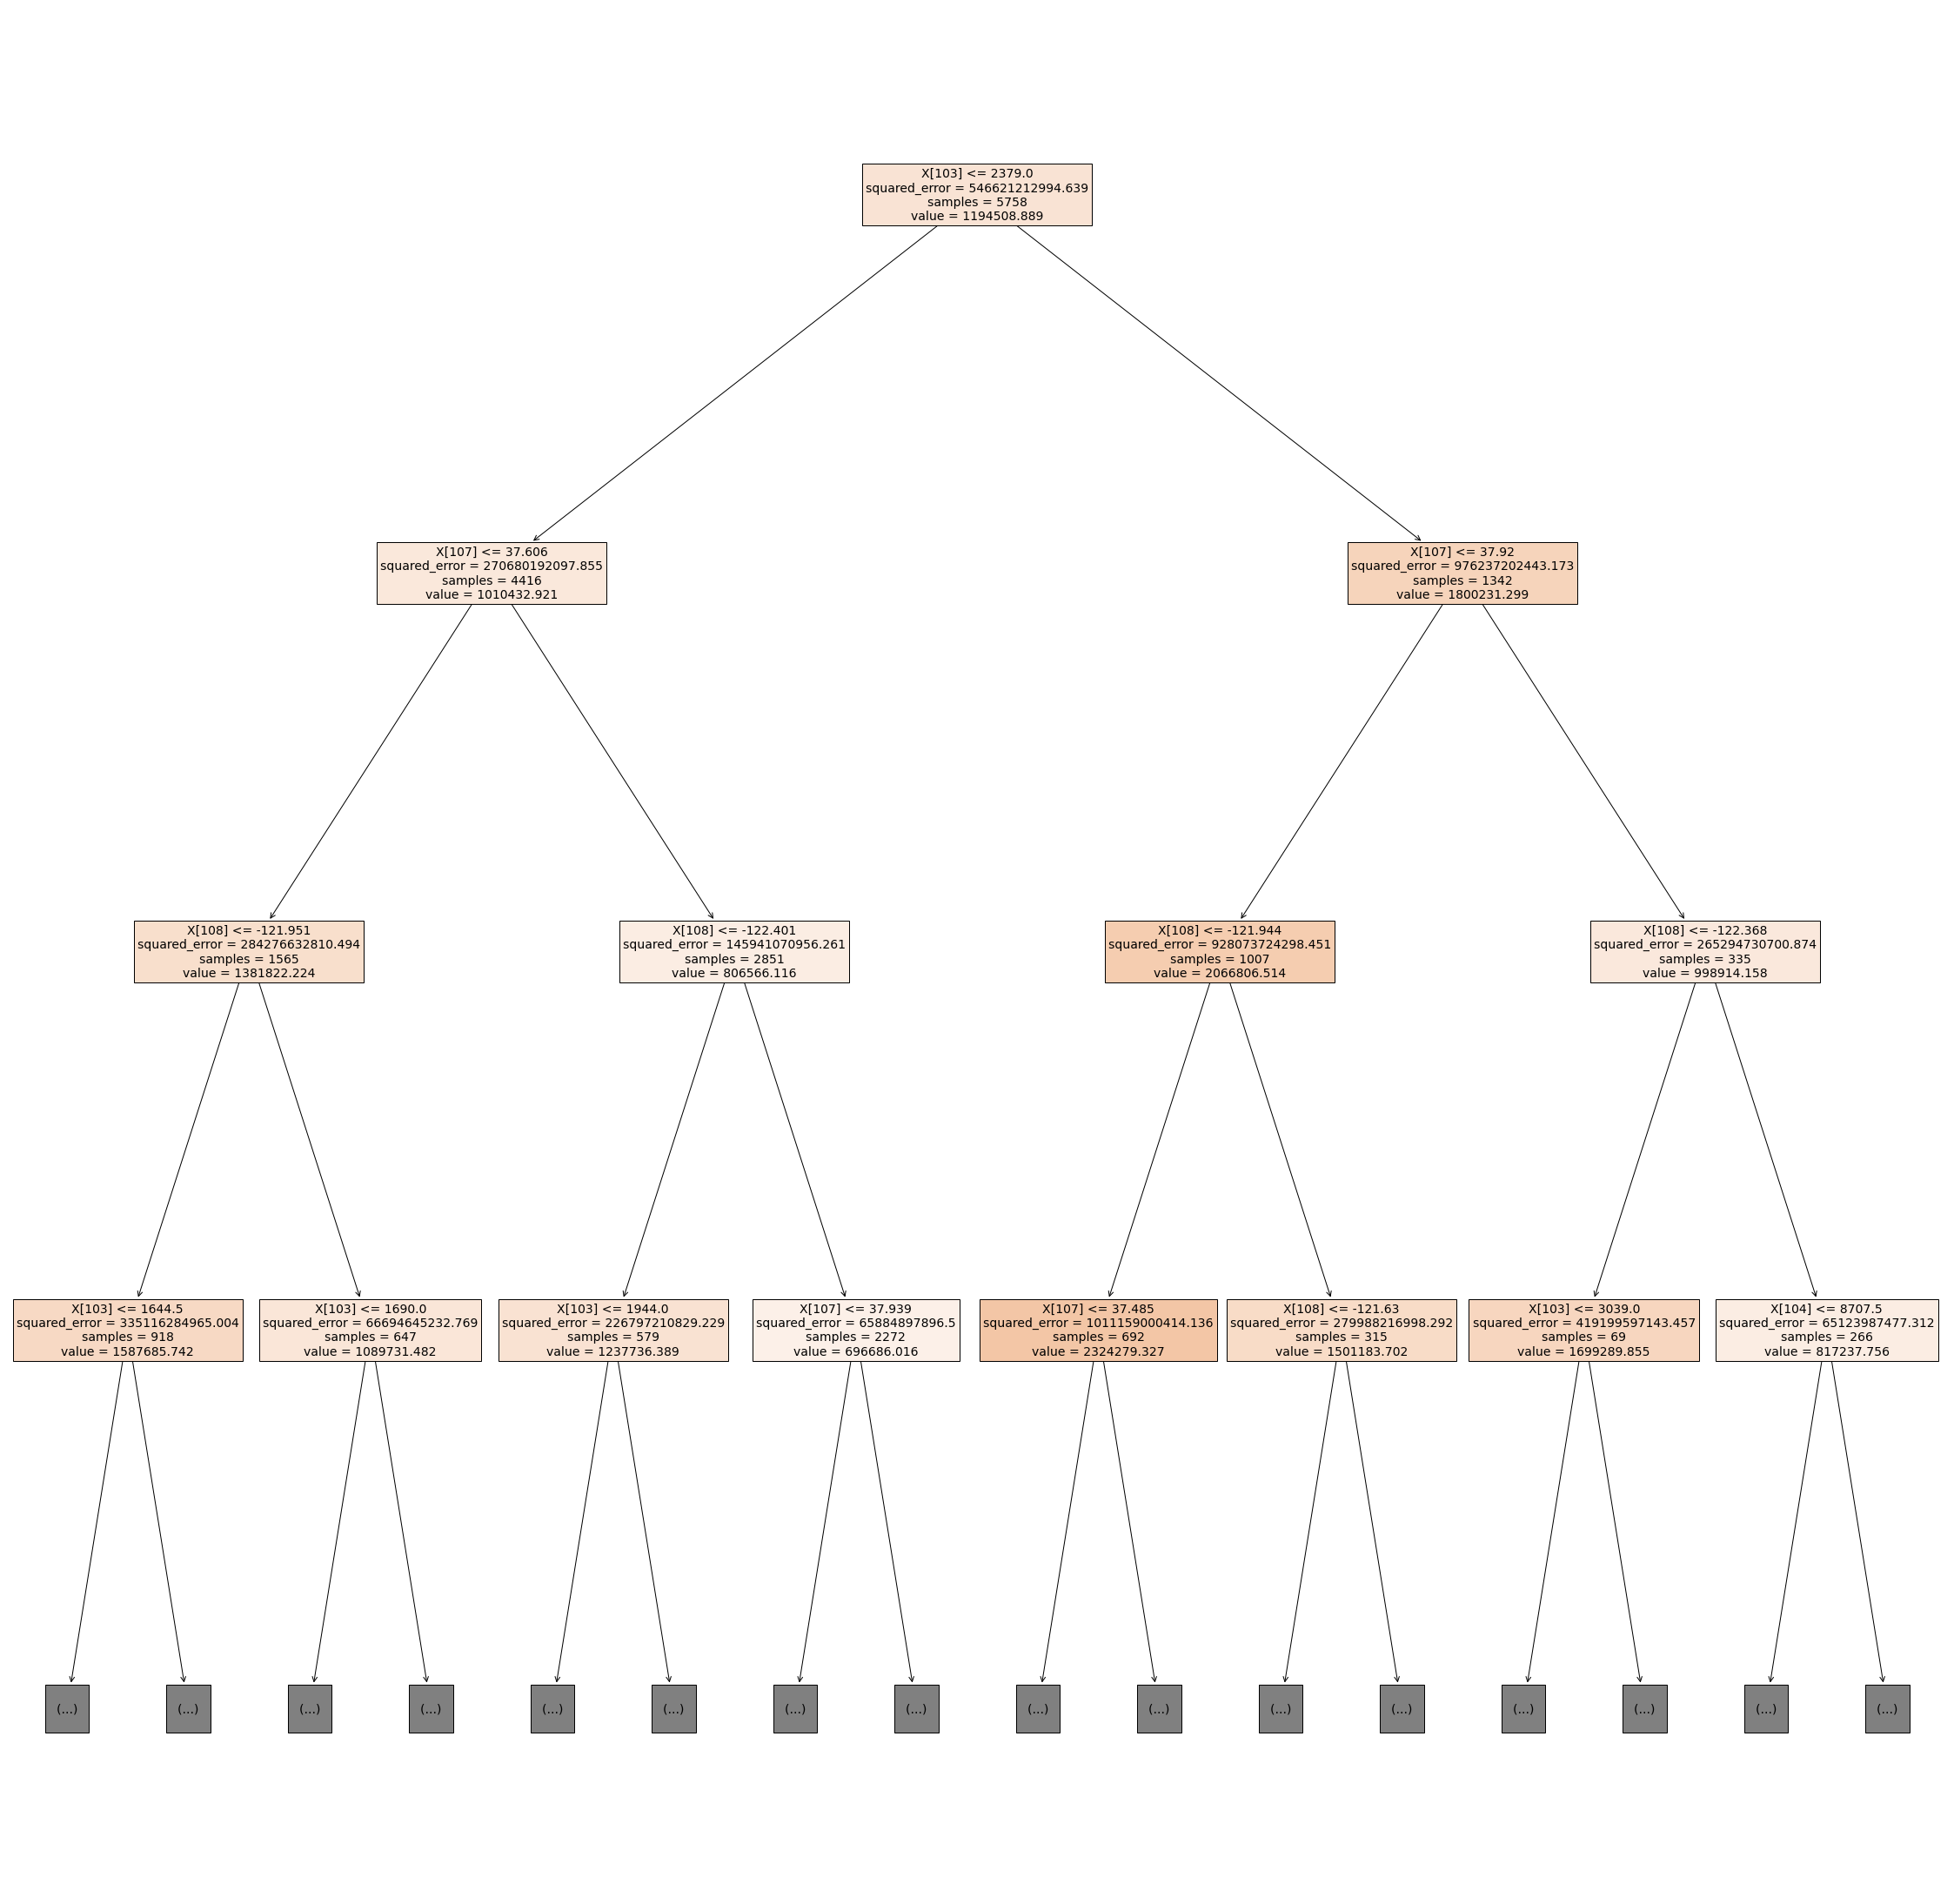

In [87]:
_, ax = plt.subplots(figsize=(40,40)) # Resize figure
tree.plot_tree(regressor, fontsize=14, max_depth=3, filled=True, ax=ax)

### Check model can run prediction given inputs 
### With arbitrary first row of training values, expect prediction = $1,595,000


City names (Spbl is San Pablo):

'Alameda', 'Alamo', 'Albany', 'Antioch', 'Atherton', 'Bay Point',
        'Belmont', 'Belvedere', 'Benicia', 'Berkeley', 'Bolinas',
        'Boulder Creek', 'Brentwood', 'Brisbane', 'Burlingame', 'Campbell',
        'Castro Valley', 'Clayton', 'Concord', 'Corte Madera', 'Crockett',
        'Cupertino', 'Daly City', 'Danville', 'Discovery Bay', 'Dublin',
        'East Palo Alto', 'El Cerrito', 'El Granada', 'El Sobrante',
        'Emeryville', 'Fairfax', 'Foster City', 'Fremont', 'Greenbrae',
        'Half Moon Bay', 'Hayward', 'Hercules', 'Hillsborough',
        'Kensington', 'Kentfield', 'La Honda', 'Lafayette', 'Larkspur',
        'Livermore', 'Los Altos', 'Los Gatos', 'Martinez', 'Menlo Park',
        'Mill Valley', 'Millbrae', 'Milpitas', 'Montara', 'Monte Sereno',
        'Moraga', 'Morgan Hill', 'Mountain House', 'Mountain View',
        'Muir Beach', 'Newark', 'Novato', 'Oakland', 'Oakley', 'Orinda',
        'Pacheco', 'Pacifica', 'Palo Alto', 'Piedmont', 'Pinole',
        'Pittsburg', 'Pleasant Hill', 'Pleasanton', 'Point Richmond',
        'Portola Valley', 'Redwood City', 'Richmond', 'Rodeo',
        'San Anselmo', 'San Bruno', 'San Carlos', 'San Francisco',
        'San Jose', 'San Leandro', 'San Lorenzo', 'San Mateo', 'San Pablo',
        'San Rafael', 'San Ramon', 'Santa Clara', 'Saratoga', 'Sausalito',
        'South San Francisco', 'Spbl', 'Stanford', 'Stinson Beach',
        'Sunnyvale', 'Sunol', 'Tiburon', 'Tracy', 'Union City', 'Vallejo',
        'Walnut Creek', 'Woodside'

In [88]:
with open('house_price_model.pkl', 'rb') as pickle_in:
  model = pickle.load(pickle_in) 
  home_size = 2220.0 
  lot_size = 3999.0
  beds = 4
  baths = 2.0 
  latitude = 37.521972
  longitude = -122.294079 	
  city = 'Belmont'
  # get prediction
  input_cols = [[home_size, lot_size, beds, baths, latitude, longitude, city]]
  input_df = pd.DataFrame(
            data=input_cols, 
            index=np.arange(len(input_cols)), 
            columns=['Home_size', 'Lot_size', 'Beds', 'Baths', 'Latitude', 'Longitude', 'City']
        )
  prepared_data = pipeline.transform(input_df)
  prediction = model.predict(prepared_data)
  output = round(prediction[0], 2)
  print('Your predicted house price: $' + str(output))

Your predicted house price: $1595000.0
